# Description

The notebook shows how to perform time series prediction using the Prophet model developed by Facebook.

References:
- White paper: `https://peerj.com/preprints/3190.pdf`
- Official docs: `https://facebook.github.io/prophet/docs/quick_start.html`

# Imports

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import logging

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import prophet as prh
import prophet.diagnostics as diagnostics
import plotly.graph_objects as go
import prophet.plot as plo
import prophet.utilities as prhu

import sklearn.metrics as metrics
import scipy.stats as stats

import helpers.hprint as hprint
import helpers.hdbg as hdbg
import helpers.hpandas as hpanda

In [3]:
hdbg.init_logger(verbosity=logging.INFO)

_LOG = logging.getLogger(__name__)

hprint.config_notebook()

INFO  > cmd='/venv/lib/python3.12/site-packages/ipykernel_launcher.py -f /home/.local/share/jupyter/runtime/kernel-2178bd9e-708d-4d8a-b0c8-3c3bccf3dd0b.json'


# Config

In [4]:
config = {
    # Train/test split.
    "train_start_date": "2020-01-01",
    "train_end_date": "2023-12-31",
    "test_start_date": "2024-01-01",
    "test_end_date": "2024-12-31",
    "data": {
        # Linear trend params.
        "slope": 0.005,
        "intercept": 15,
        # Fourier term params for seasonality component.
        "weekly_amp_sin": 5.0,
        "weekly_amp_cos": 2.5,
        # List of holidays and their impact.
        "holidays_dates": ['2020-12-25', '2021-12-25', '2022-12-25', "2023-12-25", "2024-12-25"],
        "holidays_impact": 2.5,
        # Autoregression params.
        "ar_order": 1,
        "phi": 0.7,
        # Noise std.
        "seed": 42,
        "noise_sigma": 2.0,
    },
    "model": {
        # Defines trend shape.
        "growth":"linear", 
        "yearly_seasonality":False, 
        # Integer defines Fourier order.
        "weekly_seasonality":1, 
        "daily_seasonality":False, 
        "n_changepoints":0, 
        # Prophet internally scales the target variable.
        "scaling":"minmax", 
        # Confidence iterval width.
        "interval_width":0.95,
        # Number of MCMC samples; If `mcmc_samples = 0`, the model produces just a point estimate  of each
        # parameter instead of the full distribution.
        "mcmc_samples":300,
        # Set lower prior scale to narrow the confidence interval.
        "holidays_prior_scale":0.1,
    },
}
print(config)

{'train_start_date': '2020-01-01', 'train_end_date': '2023-12-31', 'test_start_date': '2024-01-01', 'test_end_date': '2024-12-31', 'data': {'slope': 0.005, 'intercept': 15, 'weekly_amp_sin': 5.0, 'weekly_amp_cos': 2.5, 'holidays_dates': ['2020-12-25', '2021-12-25', '2022-12-25', '2023-12-25', '2024-12-25'], 'holidays_impact': 2.5, 'ar_order': 1, 'phi': 0.7, 'seed': 42, 'noise_sigma': 2.0}, 'model': {'growth': 'linear', 'yearly_seasonality': False, 'weekly_seasonality': 1, 'daily_seasonality': False, 'n_changepoints': 0, 'scaling': 'minmax', 'interval_width': 0.95, 'mcmc_samples': 300, 'holidays_prior_scale': 0.1}}


# Generate data

In [5]:
# Generate date range.
dates = pd.date_range(start=config["train_start_date"], end=config["test_end_date"], freq='D')
time = np.arange(len(dates))
# Define linear trend.
y_trend = config["data"]["slope"] * time + config["data"]["intercept"]
# Define the seasonality factor.
p_weekly = 7
y_weekly_seasonality = config["data"]["weekly_amp_sin"] * np.sin(2 * np.pi * time / p_weekly) + config["data"]["weekly_amp_cos"] * np.cos(2 * np.pi * time / p_weekly)
# Define holidays impact.
holiday_effect = np.zeros(len(dates))
holiday_effect[np.isin(dates.date, pd.to_datetime(config["data"]["holidays_dates"]).date)] = config["data"]["holidays_impact"]
# Define white noise.
np.random.seed(config["data"]["seed"])
noise = np.random.normal(loc=0, scale=config["data"]["noise_sigma"], size=len(time))
# Add autoregressive behavior.
y = np.zeros(len(time))
y[0] = y_trend[0] + y_weekly_seasonality[0] + holiday_effect[0] + noise[0]
for i in range(1, len(time)):
    y[i] = config["data"]["phi"] * y[i-1] + y_trend[i] + y_weekly_seasonality[i] + holiday_effect[i] + noise[i]
# Columns "ds" for timestamp and "y" for target variable is necessary in prophet. https://facebook.github.io/prophet/docs/quick_start.html
df = pd.DataFrame({"ds": dates, "y": y})
# Add lagged value of the target as a feature.
df["y.lag1"] = df["y"].shift(1)
# The first row for the lagged feature is NaN; we have to remove it because the model cannot handle NaNs
df = df.dropna()
_LOG.info(hpanda.df_to_str(df, log_level=logging.INFO))

ds          y     y.lag1
1     2020-01-02 00:00:00  33.141753  18.493428
2     2020-01-03 00:00:00  43.822941  33.141753
3     2020-01-04 00:00:00  48.654115  43.822941
                      ...        ...        ...
1824  2024-12-29 00:00:00  78.387492  83.360033
1825  2024-12-30 00:00:00  74.449184  78.387492
1826  2024-12-31 00:00:00  71.713198  74.449184

INFO  None


<Axes: title={'center': 'Original data'}, xlabel='Time', ylabel='Target variable'>

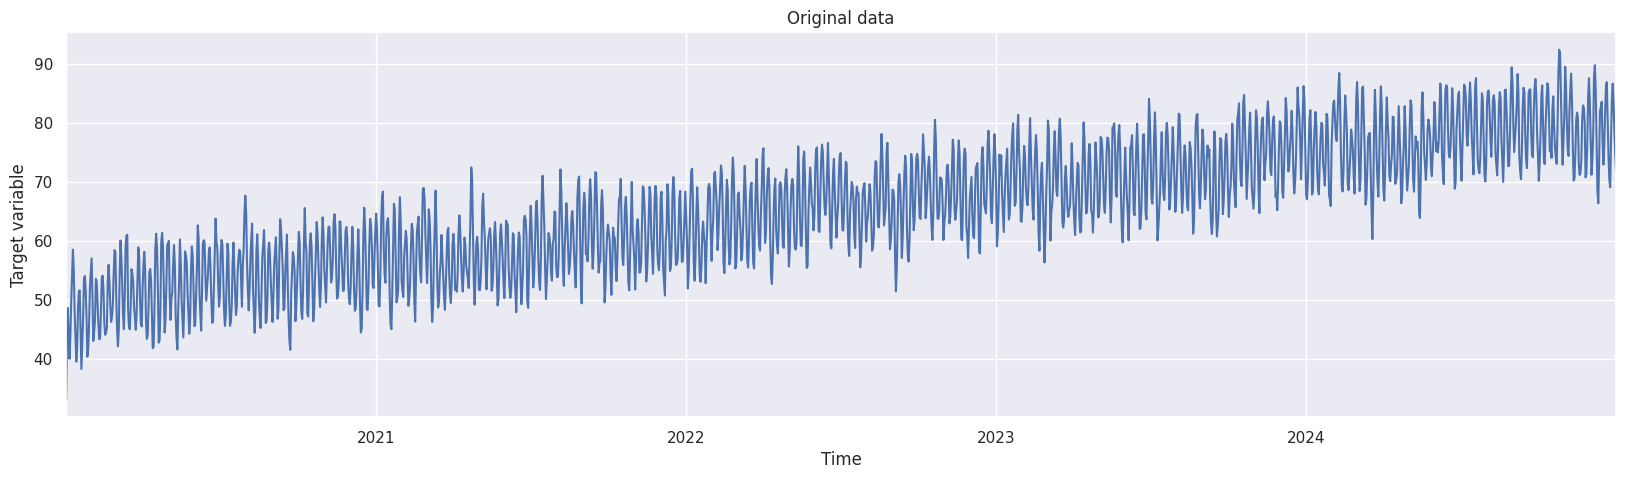

In [6]:
df.set_index("ds")["y"].plot(title="Original data", ylabel="Target variable", xlabel="Time")

# Fit the model

In [7]:
start_date_filter = df["ds"] >= config["train_start_date"]
end_date_filter = df["ds"] <= config["train_end_date"]
df_train = df[start_date_filter & end_date_filter]
_LOG.info(hpanda.df_to_str(df_train, log_level=logging.INFO))

ds          y     y.lag1
1     2020-01-02 00:00:00  33.141753  18.493428
2     2020-01-03 00:00:00  43.822941  33.141753
3     2020-01-04 00:00:00  48.654115  43.822941
                      ...        ...        ...
1458  2023-12-29 00:00:00  86.189145  81.430431
1459  2023-12-30 00:00:00   83.89076  86.189145
1460  2023-12-31 00:00:00  76.324779   83.89076

INFO  None


In Prophet, holidays can be customized to account for their effects on time series data.
Each holiday is defined as a specific date or set of recurring dates. 
Additionally, you can extend the influence of a holiday to a range of days using 
the `lower_window` and `upper_window` parameters:

 - `lower_window`: Specifies how many days before the holiday the effect starts.
 - `upper_window`: Specifies how many days after the holiday the effect ends.

For example:
 - To include Christmas Eve as part of the Christmas holiday effect, set 
   `lower_window=-1` and `upper_window=0`.
 - To include Black Friday in addition to Thanksgiving, set 
   `lower_window=0` and `upper_window=1`.

Additionally, you can customize the strength of the holiday effect for each holiday 
using the `prior_scale` parameter. This allows finer control over the regularization 
of each holiday's effect, balancing flexibility and overfitting.



In [8]:
# Construct a Dataframe with holidays.
holidays_df = pd.DataFrame({
    'holiday': ['Christmas 2020', 'Christmas 2021', 'Christmas 2022', "Christmas 2023", "Christmas 2024"],
    'ds': pd.to_datetime(config["data"]["holidays_dates"]),
    'lower_window': 0, 
    'upper_window': 0,   
})
_LOG.info(hpanda.df_to_str(holidays_df, log_level=logging.INFO))

holiday         ds  lower_window  upper_window
0  Christmas 2020 2020-12-25             0             0
1  Christmas 2021 2021-12-25             0             0
2  Christmas 2022 2022-12-25             0             0
3  Christmas 2023 2023-12-25             0             0
4  Christmas 2024 2024-12-25             0             0

INFO  None


In [9]:
model = prh.Prophet(**config["model"], holidays=holidays_df)
# Explicitly add the lagged feature as an external regressor.
model.add_regressor('y.lag1')
model.fit(df_train)

07:18:44 - cmdstanpy - INFO - CmdStan start processing


INFO  CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

07:18:59 - cmdstanpy - INFO - CmdStan done processing.



INFO  CmdStan done processing.


07:18:59 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Scal

WARNING Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Scale vector is 0, but must b

Dimensionality:
- k (Mx1 array): M posterior samples of the initial slope
- m (Mx1 array): The initial intercept
- delta (MxN array): The slope change at each of N changepoints
- beta (MxK matrix): Coefficients for K seasonality features
- sigma_obs (Mx1 array): Noise level
- M=1 (meaning that only the point estimate is available) if MAP estimation, i.e. `mcmc_samples=0` 

The number M (posterior samples) depends on:
- `mcmc_samples` provided by the user
- number of chains and the model internal mechanics that the user does not control
   - E.g., Prophet might be discarding some samples (e.g., through thinning) to reduce autocorrelation between the samples or to improve convergence

Scaling:
- Prophet perofrorms scaling internally, i.e. time is mapped to be on [0, 1] and Y is scaled by model.y_scale
- Where `y_scale` is controlled by the user and can be `absmax` or `minmax` scaling 
- TODO(Grisha): consider rescaling coefficients in order to compare them to the ground truth

In [10]:
_LOG.info("Model Scale: %s, Model Min: %s", model.y_scale, model.y_min)

INFO  Model Scale: 53.04739142107461, Model Min: 33.141753128860344


INFO  Shape of the intercept = (600,)
INFO  Intercept point estimate = 0.4776032950000001


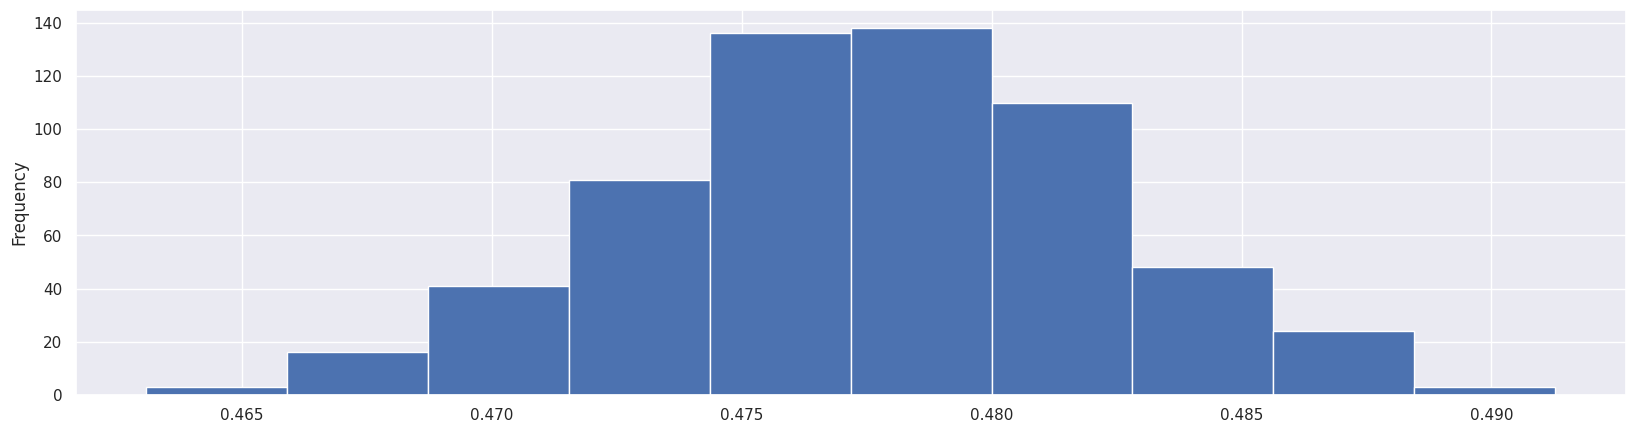

In [11]:
estimated_intercept = model.params["m"]
pd.Series(estimated_intercept).plot(kind="hist")
_LOG.info("Shape of the intercept = %s", estimated_intercept.shape)
_LOG.info("Intercept point estimate = %s", estimated_intercept.mean())

INFO  Shape of the slope = (600,)
INFO  Slope point estimate = 0.1481895134325


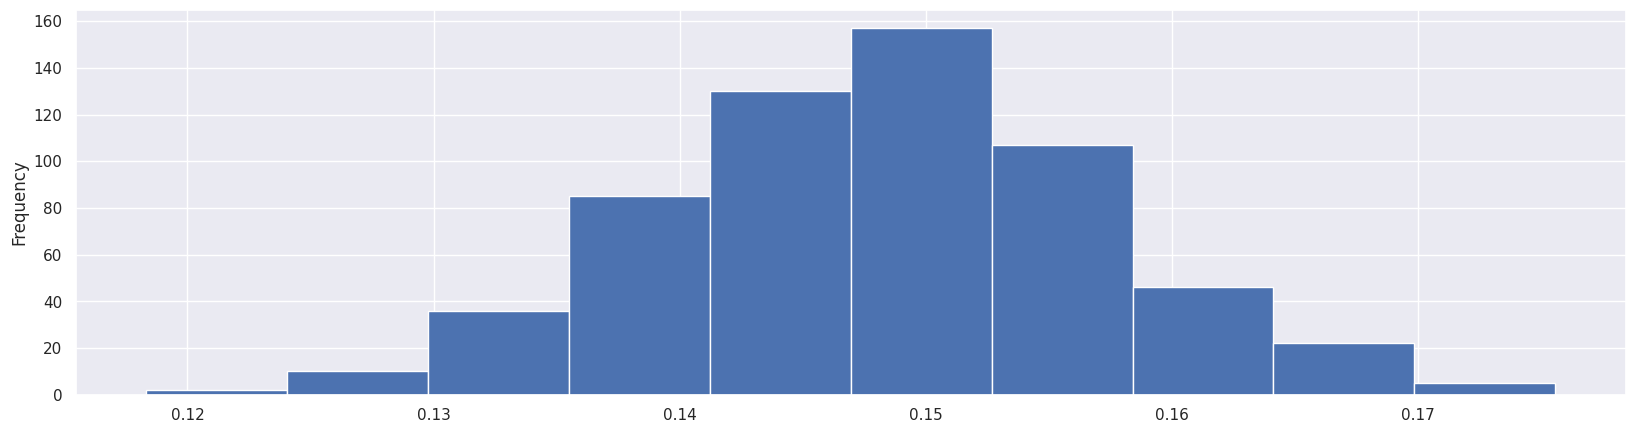

In [12]:
estimated_slope = model.params["k"]
pd.Series(estimated_slope).plot(kind="hist")
_LOG.info("Shape of the slope = %s", estimated_slope.shape)
_LOG.info("Slope point estimate = %s", estimated_slope.mean())

Estimated value of the autoregression coefficient is close to the ground truth.

In [13]:
# Use `regressor_coefficients()` to extract external regressors' coefficient. Unlike the other coeficients these
# already takes into account the internal scaling, thus can be directly compared to the original coefficients.
regressor_coefficients = prhu.regressor_coefficients(model)
_LOG.info(hpanda.df_to_str(regressor_coefficients, log_level=logging.INFO))
_LOG.info("True value of the autoregression coefficient = %s", config["data"]["phi"])

regressor regressor_mode     center  coef_lower      coef  coef_upper
0    y.lag1       additive  62.375947    0.655713  0.690275    0.722362

INFO  None
INFO  True value of the autoregression coefficient = 0.7


Description:
- `weekly_delim_1` is the coefficient for the sine term
- `weekly_delim_2` is the coefficient for the cosine term
- in general the number of the Fourier coefficients is 2xN (i.e. 1 for the sine and 1 for the cosine), where N is Fourier order (i.e. 1 in our case)
- then we have 5 coefficients for 5 holidays
- and finally coefficients for the lagged feature
- each coefficient is a vector of length M (number of posterior samples)

Once the params are extracted:
- one can easily obtain a point estimate by averaging the values within a column
- compute confidence intervals using `np.quatile()`
- study the entire parameter's distribution

In [14]:
# Use this table to identify coefficients' indices in the regressors' matrix.
col_names = model.make_all_seasonality_features(df_train)[0].columns 
coefficients_df = pd.DataFrame(model.params["beta"], columns = col_names)
_LOG.info(hpanda.df_to_str(coefficients_df, log_level=logging.INFO))

weekly_delim_1 weekly_delim_2 Christmas 2020_delim_+0 Christmas 2021_delim_+0 Christmas 2022_delim_+0 Christmas 2023_delim_+0 Christmas 2024_delim_+0    y.lag1
0         0.022705       0.102236                 0.05331                0.086244                0.057838                0.083407                0.122163  0.122164
1         0.021932       0.100979                0.011271                0.050688               -0.007356                0.072975                0.036043  0.121675
2         0.024747       0.100119                0.003038                0.082673                0.046549               -0.000326               -0.214407  0.116573
               ...            ...                     ...                     ...                     ...                     ...                     ...       ...
597       0.024911       0.103895                0.012381                0.112561                0.033201                 0.02838               -0.066533  0.120982
598       0.026506       0.101878               -0.025908                 0.06266                0.029938                0.070925                  0.0181   0.11661
599       0.020632       0.102102                0.046784               -0.011533               -0.044546                0.048871                0.092694  0.123688

INFO  None


# Predict

In [15]:
start_date_filter = df["ds"] >= config["test_start_date"]
end_date_filter = df["ds"] <= config["test_end_date"]
df_test = df[start_date_filter & end_date_filter].reset_index(drop=True)
_LOG.info(hpanda.df_to_str(df_test, log_level=logging.INFO))

ds          y     y.lag1
0    2024-01-01 00:00:00  67.852807  76.324779
1    2024-01-02 00:00:00  67.038486  67.852807
2    2024-01-03 00:00:00  70.040899  67.038486
                     ...        ...        ...
363  2024-12-29 00:00:00  78.387492  83.360033
364  2024-12-30 00:00:00  74.449184  78.387492
365  2024-12-31 00:00:00  71.713198  74.449184

INFO  None


In [16]:
# Predict on the entire data and then analyze the tran and test split seperately to gain more insights.
forecast = model.predict(df)
forecast = forecast.merge(df, how="inner", on=["ds"])
forecast["residual"] = forecast["y"] - forecast["yhat"]
_LOG.info(hpanda.df_to_str(forecast, log_level=logging.INFO))

ds      trend yhat_lower yhat_upper trend_lower trend_upper Christmas 2020 Christmas 2020_lower Christmas 2020_upper Christmas 2021 Christmas 2021_lower Christmas 2021_upper Christmas 2022 Christmas 2022_lower Christmas 2022_upper Christmas 2023 Christmas 2023_lower Christmas 2023_upper Christmas 2024 Christmas 2024_lower Christmas 2024_upper additive_terms additive_terms_lower additive_terms_upper extra_regressors_additive extra_regressors_additive_lower extra_regressors_additive_upper holidays holidays_lower holidays_upper    weekly weekly_lower weekly_upper   y.lag1_x y.lag1_lower y.lag1_upper multiplicative_terms multiplicative_terms_lower multiplicative_terms_upper       yhat          y   y.lag1_y  residual
0     2020-01-02 00:00:00  58.477362  29.646914  37.453808   57.996614   58.950042            0.0                  0.0                  0.0            0.0                  0.0                  0.0            0.0                  0.0                  0.0            0.0                  0.0                  0.0            0.0                  0.0                  0.0     -24.803947           -26.136781           -23.356945                -30.291018                      -31.699076                      -28.774327      0.0            0.0            0.0   5.48707     5.311672     5.638845 -30.291018   -31.699076   -28.774327                  0.0                        0.0                        0.0  33.673415  33.141753  18.493428 -0.531662
1     2020-01-03 00:00:00   58.48275  38.589968  46.570746   58.002631   58.954916            0.0                  0.0                  0.0            0.0                  0.0                  0.0            0.0                  0.0                  0.0            0.0                  0.0                  0.0            0.0                  0.0                  0.0     -15.859208           -16.924006           -14.703864                -20.179641                      -21.117679                      -19.169234      0.0            0.0            0.0  4.320433     4.149011     4.516021 -20.179641   -21.117679   -19.169234                  0.0                        0.0                        0.0  42.623542  43.822941  33.141753    1.1994
2     2020-01-04 00:00:00  58.488138  41.809588   49.39752   58.008648    58.95979            0.0                  0.0                  0.0            0.0                  0.0                  0.0            0.0                  0.0                  0.0            0.0                  0.0                  0.0            0.0                  0.0                  0.0      -12.90626           -13.714229           -11.994687                -12.806681                      -13.401991                      -12.165442      0.0            0.0            0.0 -0.099579     -0.36233     0.173095 -12.806681   -13.401991   -12.165442                  0.0                        0.0                        0.0  45.581878  48.654115  43.822941  3.072237
                      ...        ...        ...        ...         ...         ...            ...                  ...                  ...            ...                  ...                  ...            ...                  ...                  ...            ...                  ...                  ...            ...                  ...                  ...            ...                  ...                  ...                       ...                             ...                             ...      ...            ...            ...       ...          ...          ...        ...          ...          ...                  ...                        ...                        ...        ...        ...        ...       ...
1823  2024-12-29 00:00:00  68.299655  74.623925  82.135044   67.633927   69.071258            0.0                  0.0                  0.0            0.0                  0.0                  0.0            0.0                  0.0                  0.0            0.0                  0.0         

INFO  None


# Analyze the results

In [17]:
ins_forecast = forecast[forecast["ds"]<=config["train_end_date"]]
ins_forecast.tail(5)

ds      trend  yhat_lower  yhat_upper  trend_lower  trend_upper  Christmas 2020  Christmas 2020_lower  Christmas 2020_upper  Christmas 2021  Christmas 2021_lower  Christmas 2021_upper  Christmas 2022  Christmas 2022_lower  Christmas 2022_upper  Christmas 2023  Christmas 2023_lower  Christmas 2023_upper  Christmas 2024  Christmas 2024_lower  Christmas 2024_upper  additive_terms  additive_terms_lower  additive_terms_upper  extra_regressors_additive  extra_regressors_additive_lower  extra_regressors_additive_upper  holidays  holidays_lower  holidays_upper    weekly  weekly_lower  weekly_upper   y.lag1_x  y.lag1_lower  y.lag1_upper  multiplicative_terms  multiplicative_terms_lower  multiplicative_terms_upper       yhat          y   y.lag1_y  residual
1455 2023-12-27  66.316877   70.806130   78.243486    65.872765    66.836824             0.0                   0.0                   0.0             0.0                   0.0                   0.0             0.0                   0.0                   0.0             0.0                   0.0                   0.0             0.0                   0.0                   0.0        8.086775              7.557150              8.566845                   5.564943                         5.286303                         5.823626       0.0             0.0             0.0  2.521832      2.251693      2.774962   5.564943      5.286303      5.823626                   0.0                         0.0                         0.0  74.403653  75.593189  70.437866  1.189537
1456 2023-12-28  66.322265   77.263013   84.816116    65.877482    66.842812             0.0                   0.0                   0.0             0.0                   0.0                   0.0             0.0                   0.0                   0.0             0.0                   0.0                   0.0             0.0                   0.0                   0.0       14.610606             14.048348             15.127682                   9.123536                         8.666714                         9.547637       0.0             0.0             0.0  5.487070      5.311672      5.638845   9.123536      8.666714      9.547637                   0.0                         0.0                         0.0  80.932871  81.430431  75.593189  0.497560
1457 2023-12-29  66.327653   79.720984   87.728079    65.882199    66.848800             0.0                   0.0                   0.0             0.0                   0.0                   0.0             0.0                   0.0                   0.0             0.0                   0.0                   0.0             0.0                   0.0                   0.0       17.473272             16.922466             17.998162                  13.152839                        12.494268                        13.764241       0.0             0.0             0.0  4.320433      4.149011      4.516021  13.152839     12.494268     13.764241                   0.0                         0.0                         0.0  83.800926  86.189145  81.430431  2.388219
1458 2023-12-30  66.333041   78.996077   86.742361    65.886917    66.854788             0.0                   0.0                   0.0             0.0                   0.0                   0.0             0.0                   0.0                   0.0             0.0                   0.0                   0.0             0.0                   0.0                   0.0       16.338083             15.745448             16.902420                  16.437662                        15.614618                        17.201756       0.0             0.0             0.0 -0.099579     -0.362330      0.173095  16.437662     15.614618     17.201756                   0.0                         0.0                         0.0  82.671124  83.890760  86.189145  1.219636
1459 2023-12-31  66.338429   72.746082   80.497011    65.891634    66.860776             0.0                   0.0                   0.0             0.0           

<Axes: >

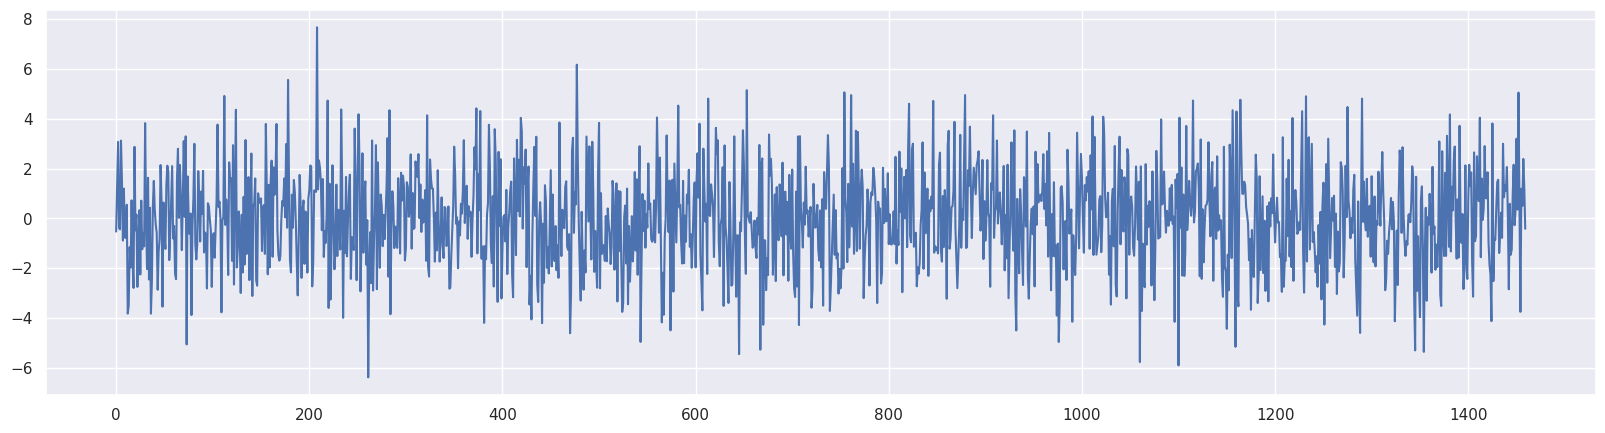

In [18]:
ins_forecast["residual"].plot()

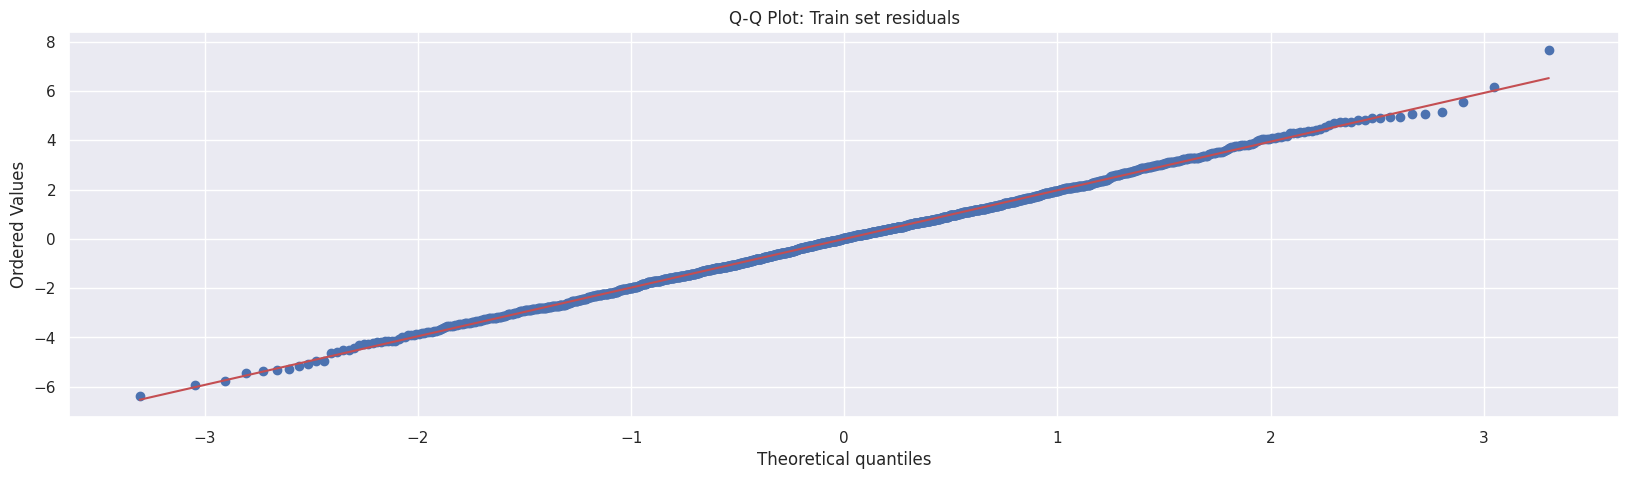

In [19]:
stats.probplot(ins_forecast["residual"], dist="norm", plot=plt)
plt.title("Q-Q Plot: Train set residuals")
plt.show()

Residuals are normal distributed, hence the modle is working fine.

Text(0.5, 1.0, 'Observed vs predicted data, train set')

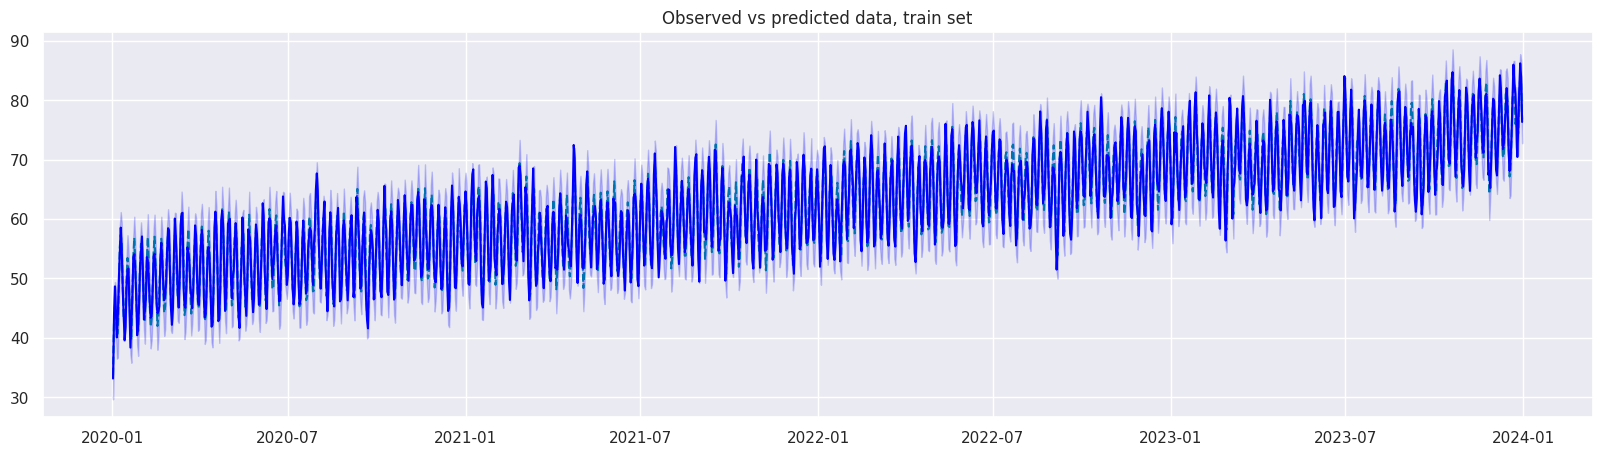

In [20]:
plt.plot(ins_forecast["ds"], ins_forecast["yhat"], label="Point Estimate", ls='--', c='#0072B2')
plt.plot(ins_forecast["ds"], ins_forecast["y"], label="Observed data", color="blue")

# Plot confidence/prediction intervals
plt.fill_between(
    ins_forecast["ds"],
    ins_forecast["yhat_lower"],
    ins_forecast["yhat_upper"],
    color="blue",
    alpha=0.2,
    label="Confidence Interval",
)
plt.title("Observed vs predicted data, train set")

### `Prophet.plot()`

The `Prophet.plot()` function is used to visualize the forecast generated by the Prophet model. It provides a comprehensive view of the predicted trend and uncertainty intervals over the forecast horizon.

**Key Features:**
1. **Forecast Line**: Displays the predicted values (`yhat`), representing the central forecast.
2. **Uncertainty Intervals**:
   - Shaded regions represent the uncertainty intervals (`yhat_lower` and `yhat_upper`), capturing the range within which the forecast is expected to fall.
   - By default, this represents a 95% confidence interval.
3. **Historical Data**:
   - Overlaid as points to show how the forecast aligns with the actual data.

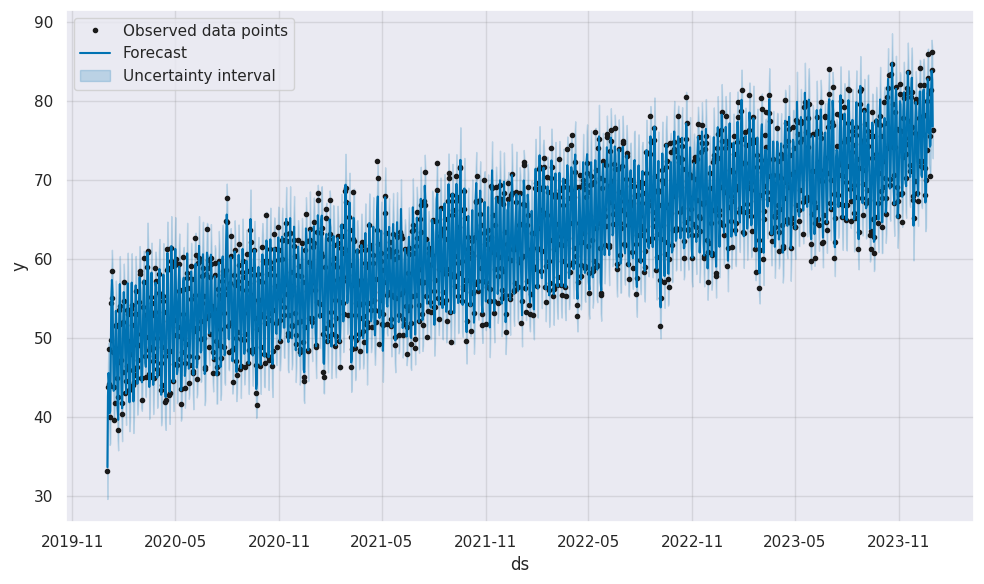

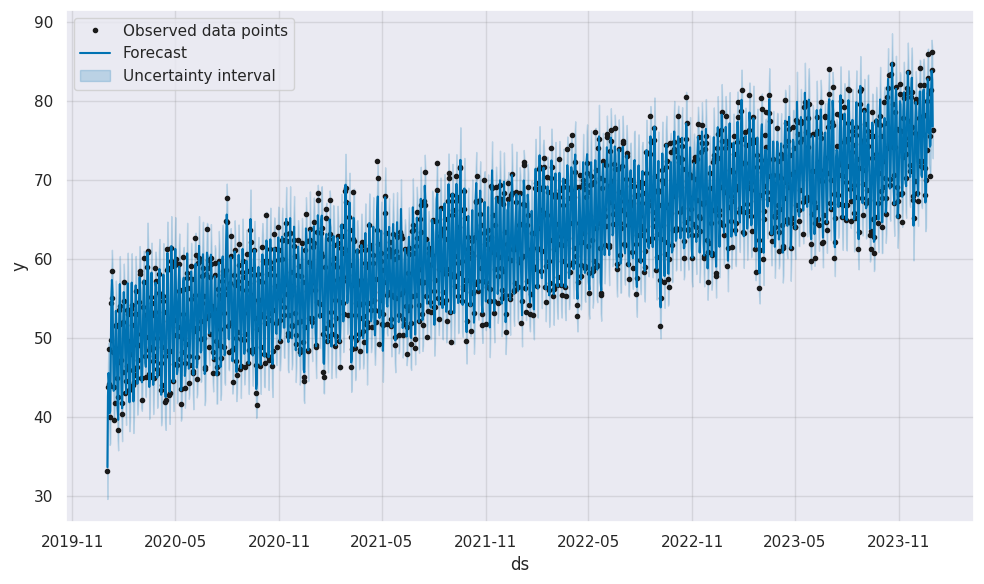

In [21]:
model.plot(ins_forecast, include_legend=True)

### `Prophet.plot_components()`

The `Prophet.plot_components()` function provides a breakdown of the individual components contributing to the forecast. This helps understand **why** the forecast behaves as it does.

**Components Visualized:**
1. **Trend**:
   - Displays the underlying trend in the data, excluding seasonality and holidays.
   - Useful for identifying long-term growth or decline patterns.
2. **Seasonality**:
   - Shows recurring patterns (e.g., daily, weekly, yearly seasonality) identified from the data.
   - If multiple seasonalities are specified, they are plotted separately.
3. **Holidays (if applicable)**:
   - Visualizes the effect of specified holidays on the forecast.
   - Helps identify spikes or dips caused by holidays.

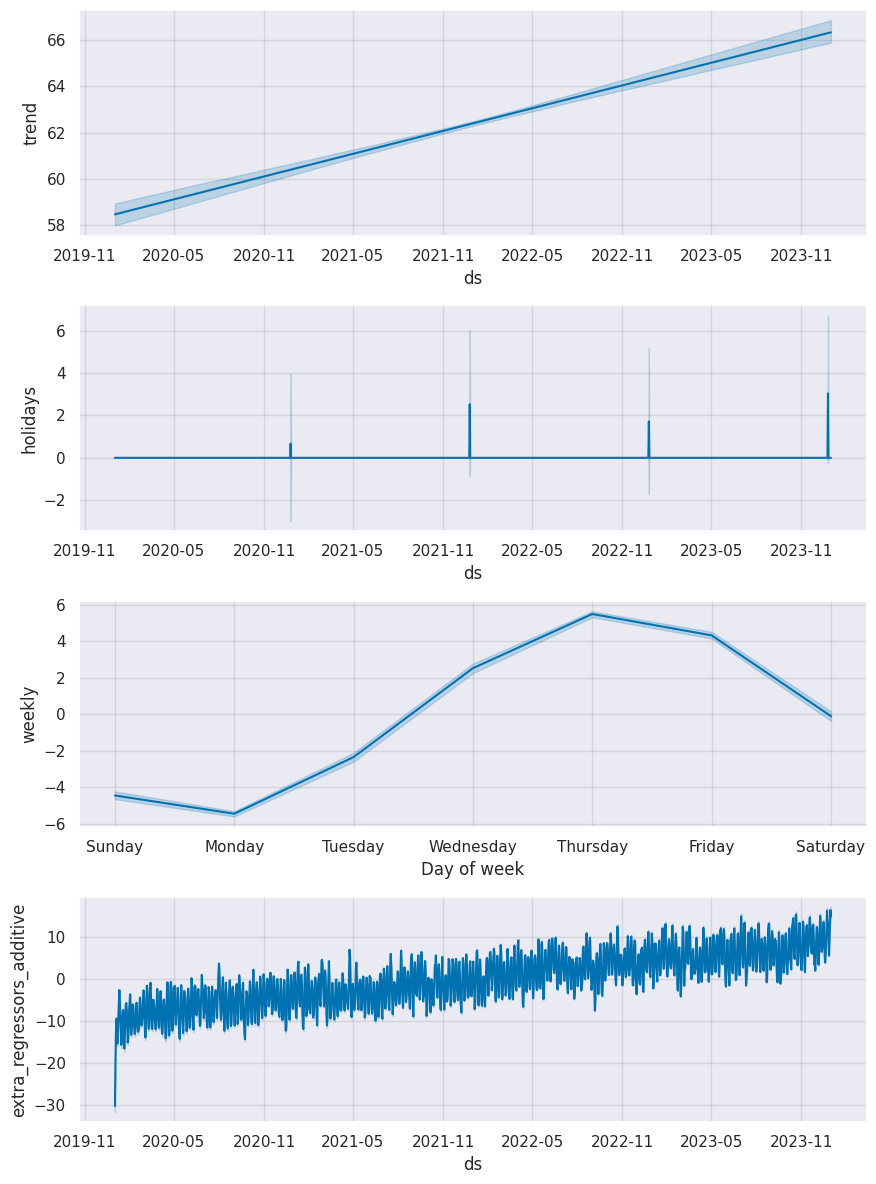

In [22]:
fig2 = model.plot_components(ins_forecast)

In [23]:
oos_forecast = forecast[forecast["ds"]>=config["test_start_date"]]
oos_forecast.tail(5)

ds      trend  yhat_lower  yhat_upper  trend_lower  trend_upper  Christmas 2020  Christmas 2020_lower  Christmas 2020_upper  Christmas 2021  Christmas 2021_lower  Christmas 2021_upper  Christmas 2022  Christmas 2022_lower  Christmas 2022_upper  Christmas 2023  Christmas 2023_lower  Christmas 2023_upper  Christmas 2024  Christmas 2024_lower  Christmas 2024_upper  additive_terms  additive_terms_lower  additive_terms_upper  extra_regressors_additive  extra_regressors_additive_lower  extra_regressors_additive_upper  holidays  holidays_lower  holidays_upper    weekly  weekly_lower  weekly_upper   y.lag1_x  y.lag1_lower  y.lag1_upper  multiplicative_terms  multiplicative_terms_lower  multiplicative_terms_upper       yhat          y   y.lag1_y  residual
1821 2024-12-27  68.288879   83.383874   90.940231    67.624338    69.059284             0.0                   0.0                   0.0             0.0                   0.0                   0.0             0.0                   0.0                   0.0             0.0                   0.0                   0.0             0.0                   0.0                   0.0       19.082168             18.453632             19.677530                  14.761735                        14.022605                        15.447924       0.0             0.0             0.0  4.320433      4.149011      4.516021  14.761735     14.022605     15.447924                   0.0                         0.0                         0.0  87.371047  86.611489  83.761234 -0.759558
1822 2024-12-28  68.294267   80.880836   88.940282    67.629133    69.065271             0.0                   0.0                   0.0             0.0                   0.0                   0.0             0.0                   0.0                   0.0             0.0                   0.0                   0.0             0.0                   0.0                   0.0       16.629617             16.021713             17.205794                  16.729195                        15.891554                        17.506841       0.0             0.0             0.0 -0.099579     -0.362330      0.173095  16.729195     15.891554     17.506841                   0.0                         0.0                         0.0  84.923884  83.360033  86.611489 -1.563850
1823 2024-12-29  68.299655   74.623925   82.135044    67.633927    69.071258             0.0                   0.0                   0.0             0.0                   0.0                   0.0             0.0                   0.0                   0.0             0.0                   0.0                   0.0             0.0                   0.0                   0.0       10.040191              9.482976             10.560110                  14.484796                        13.759533                        15.158113       0.0             0.0             0.0 -4.444606     -4.648019     -4.218968  14.484796     13.759533     15.158113                   0.0                         0.0                         0.0  78.339846  78.387492  83.360033  0.047646
1824 2024-12-30  68.305043   70.293389   78.029960    67.638722    69.077244             0.0                   0.0                   0.0             0.0                   0.0                   0.0             0.0                   0.0                   0.0             0.0                   0.0                   0.0             0.0                   0.0                   0.0        5.609620              5.012190              6.155598                  11.052374                        10.498974                        11.566136       0.0             0.0             0.0 -5.442754     -5.594132     -5.305169  11.052374     10.498974     11.566136                   0.0                         0.0                         0.0  73.914663  74.449184  78.387492  0.534521
1825 2024-12-31  68.310431   70.386713   78.127080    67.643516    69.083231             0.0                   0.0                   0.0             0.0           

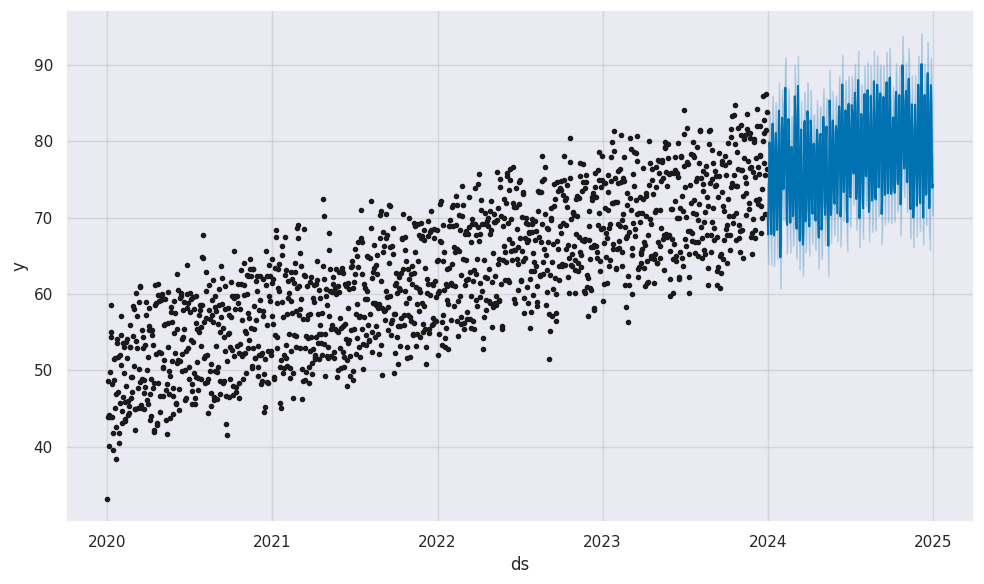

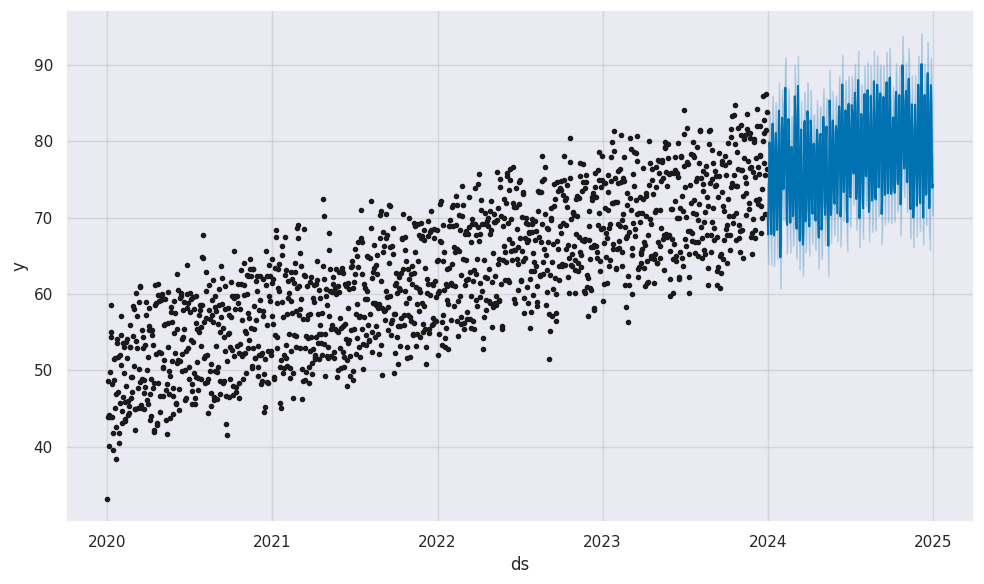

In [24]:
model.plot(oos_forecast)

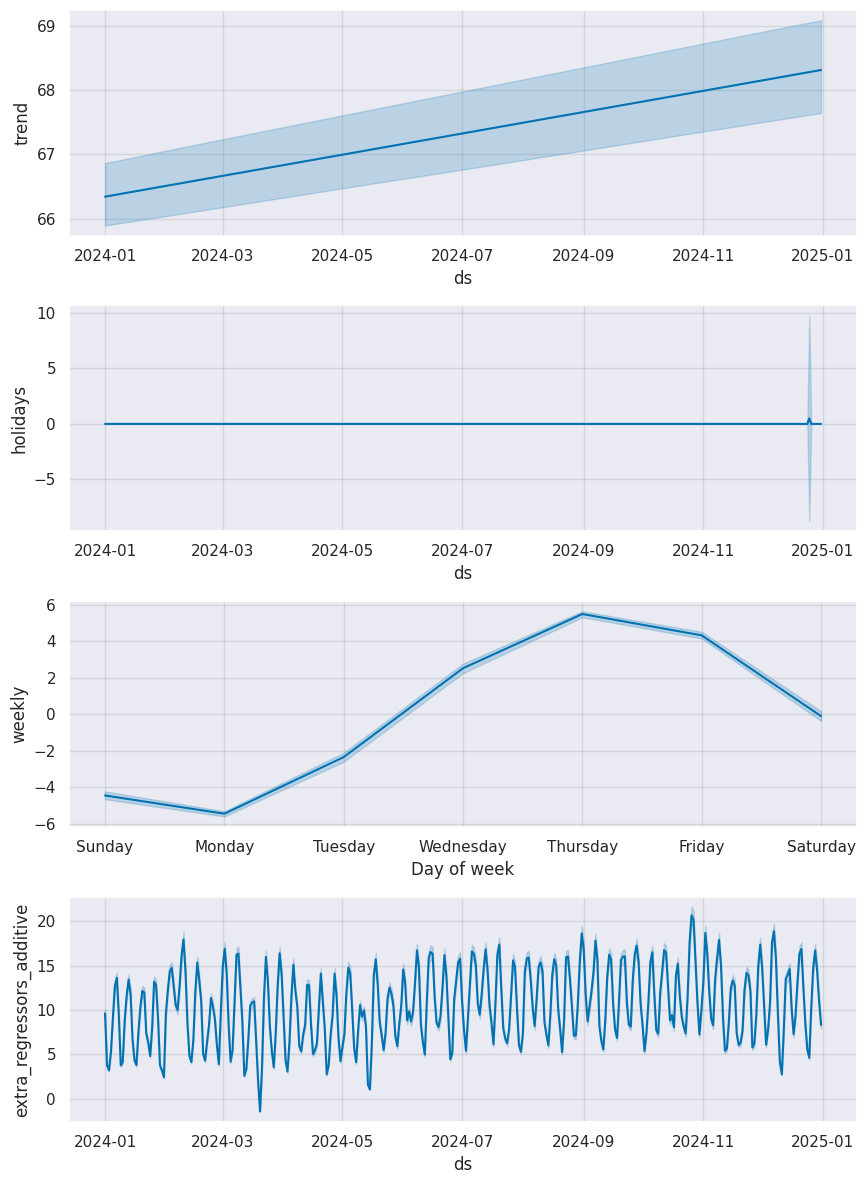

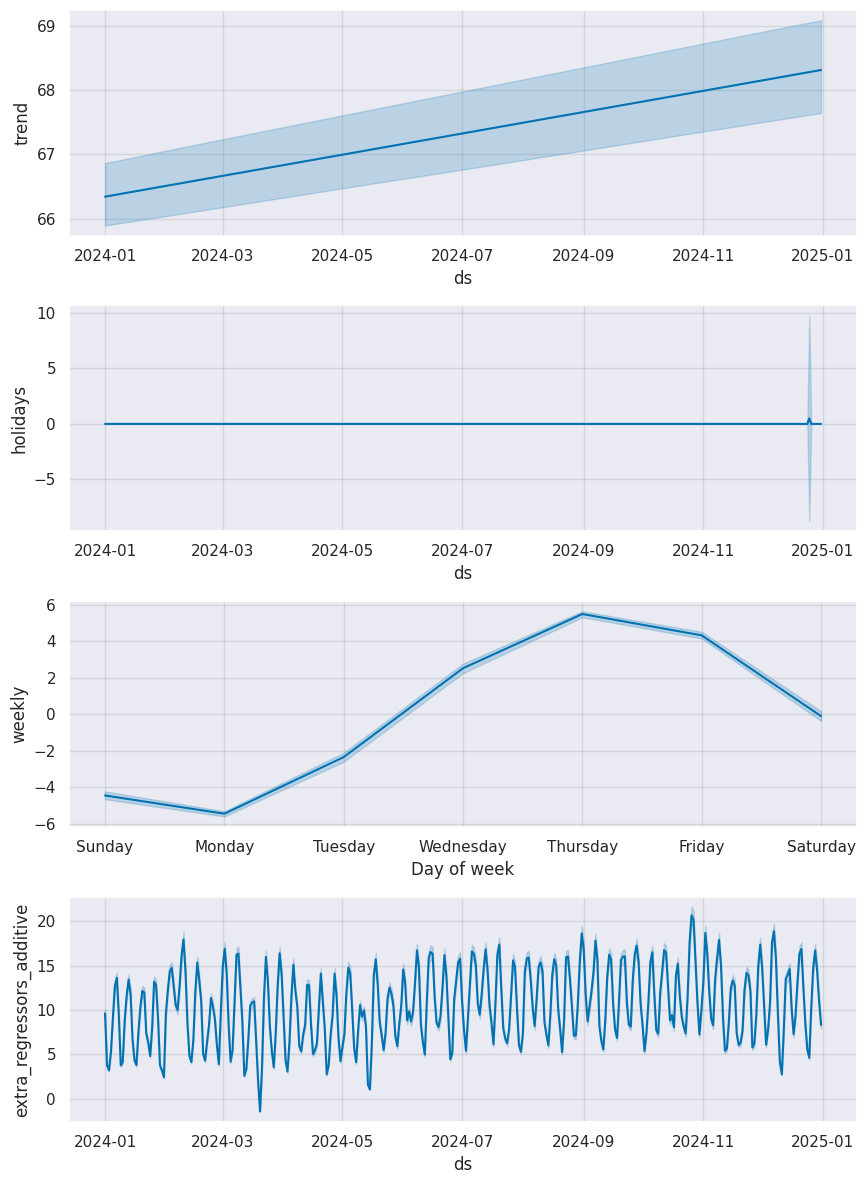

In [25]:
model.plot_components(oos_forecast)

### Prophet.plot_plotly()
The Prophet.plot_plotly() function provides an interactive visualization of the forecast using the Plotly library. This is an alternative to Prophet.plot(), which uses Matplotlib for static plots.

With plot_plotly(), you can dynamically explore the forecast, zoom in/out, hover over data points to see values, and pan through the graph, making it especially useful for presentations or exploring large datasets.

In [26]:
# Create Prophet's interactive plot
fig = plo.plot_plotly(model, forecast)

# Add ground truth (actual values)
fig.add_trace(
    go.Scatter(
        x=df_test['ds'],
        y=df_test['y'],
        mode='markers',
        name='Ground Truth',
        marker=dict(color='red', size=5)
    )
)

# Update layout
fig.update_layout(
    title="Forecast vs Ground Truth",
    xaxis_title="Date",
    yaxis_title="Values",
    legend=dict(orientation="h", y=-0.2),
)

# Show the plot
fig.show()

# Performance metrics

Prophet provides performance metric calculation only on the cross validation data. To test the performance of prophet model on test split we will be using sklearn metrics.

In [27]:
# Calculate metrics
mae = metrics.mean_absolute_error(forecast['y'], forecast['yhat'])
rmse = metrics.mean_squared_error(forecast['y'], forecast['yhat'])
mape = (abs(forecast['y'] - forecast['yhat']) / forecast['y']).mean() * 100

_LOG.info("MAE=%s, RMSE=%s, MAPE=%s", mae, rmse, mape)

INFO  MAE=1.5754039313573671, RMSE=3.9191636130208436, MAPE=2.474535294512032


# Cross Validation

- Sliding Window Approach:

The historical dataset is split into multiple training and testing sets using a sliding window approach.
Each training set ends at a specific cutoff date, and the model is tested on the subsequent data.

- Parameters:

    - initial: The size of the initial training period (e.g., 3 years).
    - horizon: The forecast horizon for which predictions are made (e.g., 30 days).
    - period: The spacing between cutoff dates (e.g., 90 days).
This setup generates overlapping training and testing periods, simulating how the model performs when trained on different subsets of the data.

Prophet's cross_validation function adheres to the rolling approach. Each fold contains:

- A training set determined by the initial parameter (e.g., the first 3 years of data).
- A validation set that starts right after the training set and spans the horizon period (e.g., 90 days into the future).
- The window is shifted forward by the period parameter (e.g., every 180 days), creating new training and validation splits.

In [28]:
df_cv = diagnostics.cross_validation(
    model=model,
    # Use 2 years as initial training period.
    initial='730 days',
    # Move rolling window every 180 days.
    period='180 days',     
    horizon='365 days'
)

INFO  Making 3 forecasts with cutoffs between 2022-01-05 00:00:00 and 2022-12-31 00:00:00


  0%|          | 0/3 [00:00<?, ?it/s]

07:19:08 - cmdstanpy - INFO - CmdStan start processing


INFO  CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

07:19:15 - cmdstanpy - INFO - CmdStan done processing.



INFO  CmdStan done processing.


07:19:15 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Matri

WARNING Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Matrix of independent variable

07:19:17 - cmdstanpy - INFO - CmdStan start processing


INFO  CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

07:19:27 - cmdstanpy - INFO - CmdStan done processing.



INFO  CmdStan done processing.


07:19:27 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_gl

WARNING Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Scale vector is 0

07:19:29 - cmdstanpy - INFO - CmdStan start processing


INFO  CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

07:19:45 - cmdstanpy - INFO - CmdStan done processing.



INFO  CmdStan done processing.


07:19:45 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Scal

WARNING Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Scale vector is 0, but must b

07:19:45 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 2 had 15 iterations at max treedepth (10.0%)
	Use the "diagnose()" method on the CmdStanMCMC object to see further information.


WARNING Some chains may have failed to converge.
	Chain 2 had 15 iterations at max treedepth (10.0%)
	Use the "diagnose()" method on the CmdStanMCMC object to see further information.


In [29]:
df_perf = performance_metrics(df_cv)
_LOG.info(hpanda.df_to_str(df_perf, log_level=logging.INFO))

NameError: name 'performance_metrics' is not defined

In [ ]:
df_cv.head()

In [ ]:
# Plot Mean Absolute Percentage Error (MAPE)
fig = plo.plot_cross_validation_metric(df_cv, metric='mape')